In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
# Matrix pretty print
# Enhanced upon reference: https://stackoverflow.com/a/13214945
def fmt_matrix(matrix, header_row = False):
    s = [[str(e) for e in row] for row in matrix]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = ''.join('| {{:{}}} '.format(x) for x in lens) + '|'
    sep_row = lambda c, sep = '|': sep.join([''] + [c*(l+2) for l in lens] + [''])
    table = [fmt.format(*row) for row in s]
    if (header_row):
        table.insert(1, sep_row('—'))
    return '\n'.join(table)

def read_data(filename):
    data, labels = [], []
    with open(filename, 'r') as f:
        for s in f.readlines():
            line = s.strip().split()
            data.append(np.array(list(map(float, line[:-1]))))
            labels.append(int(line[-1]))
    return np.array(data), np.array(labels)

In [3]:
# Reference: https://hackernoon.com/how-to-plot-a-decision-boundary-for-machine-learning-algorithms-in-python-3o1n3w07

def plot_model_regions(X, y, trained_model, plot_boundary=True, plot_scatter=True, axs=None, range=None):
    # define bounds of the plot
    if range is None:
        plot_margin = 0.25
        min1, max1 = X[:, 0].min()-plot_margin, X[:, 0].max()+plot_margin
        min2, max2 = X[:, 1].min()-plot_margin, X[:, 1].max()+plot_margin
    else:
        min1, max1, min2, max2 = range

    if axs is None:
        axs = plt.subplots(1, 1)[1]

    if plot_boundary:
        # define the x and y scale
        x1grid = np.arange(min1, max1, 0.01)
        x2grid = np.arange(min2, max2, 0.01)
        # create all of the lines and rows of the grid
        xx, yy = np.meshgrid(x1grid, x2grid)
        # flatten each grid to a vector
        r1, r2 = xx.flatten(), yy.flatten()
        r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
        # horizontal stack vectors to create x1,x2 input for the trained_model
        grid = np.hstack((r1,r2))
        # make predictions for the grid
        yhat = trained_model.predict(grid)
        # reshape the predictions back into a grid
        zz = yhat.reshape(xx.shape)
        # plot the grid of x, y and z values as a surface
        axs.contourf(xx, yy, zz, cmap='Paired')

    if plot_scatter:
        markers = ['o', '^']
        # create scatter plot for samples from each class
        for i, class_value in enumerate(np.unique(y)):
            # get row indexes for samples with this class
            row_ix = np.where(y == class_value)
            # create scatter of these samples
            axs.scatter(X[row_ix, 0], X[row_ix, 1], edgecolors='black', marker=markers[i])
    axs.axis('scaled')
    axs.set_xlim((min1,max1))
    axs.set_ylim((min2,max2))

In [4]:

class KNNModel:
    def __init__(self, k):
        self.k = k

    def fit(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train
        return self

    def calc_distance(self, x1, x2):
        return np.linalg.norm(x1-x2, axis=1)

    def predict(self, query):
        def predict_single_query(single_query):
            train_distances = self.calc_distance(single_query, self.x_train)
            k_indices = np.argsort(train_distances)[:self.k]
            predicted_class = np.bincount(self.y_train[k_indices]).argmax()
            return predicted_class
        if (len(query.shape)>1):
            return np.array(list(map(predict_single_query, query)))
        else:
            return predict_single_query(query)

    def predict_proba(self, query):
        labels = np.unique(self.y_train)
        def predict_proba_single_query(single_query):
            train_distances = self.calc_distance(single_query, self.x_train)
            k_indices = np.argsort(train_distances)[:self.k]
            k_distances = train_distances[k_indices]
            k_instances = self.y_train[k_indices]
            probs = []
            for label in labels:
                label_distances = k_distances[k_instances == label]
                if len(label_distances) == 0:
                    probs.append(0)
                else:
                    probs.append(np.sum(1/(label_distances**2 + 1e-6)))
            probs = np.array(probs)
            probs = probs/np.sum(probs) # Normalizing to scale of 1
            return probs
        if (len(query.shape)>1):
            return np.array(list(map(predict_proba_single_query, query)))
        else:
            return predict_proba_single_query(query)

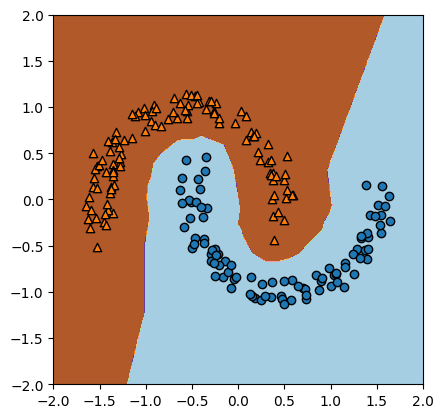

In [6]:
# Section 2 Question 1

data, labels = read_data('D2z.txt')
model = KNNModel(k=1).fit(data, labels)
plot_model_regions(data, labels, model, range=[-2, 2, -2, 2])

In [ ]:
df = pd.read_csv('emails.csv')

x_train = np.array(df[df.columns[1:-1]])
y_train = np.array(df[df.columns[-1]])

In [ ]:
# Utility functions

def generateKFolds(size, k):
    indexes = []
    n_samples = size//k
    for i in range(k):
        si = i*n_samples
        ei = si + n_samples
        train_idx = np.array(list(range(0, si)) + list(range(ei, size)), dtype=int)
        val_idx = np.array(range(si, ei), dtype=int)
        indexes.append((i+1, train_idx, val_idx))
    return indexes

# Returns (thresholds, TPRs, FPRs, accuracies, precisions)
def calculate_roc(y_true, y_pred):
    sort_index = np.argsort(y_pred)
    y_pred = y_pred[sort_index]
    y_true = y_true[sort_index]

    thresholds = []
    tprs = []
    fprs = []
    accuracies = []
    precisions = []

    for threshold in np.unique(y_pred):
        y_pred_binary = (y_pred >= threshold).astype(int)

        true_positives = ((y_true == 1) & (y_pred_binary == 1)).sum()
        false_positives = ((y_true == 0) & (y_pred_binary == 1)).sum()
        true_negatives = ((y_true == 0) & (y_pred_binary == 0)).sum()
        false_negatives = ((y_true == 1) & (y_pred_binary == 0)).sum()

        # Adding 1e-6 to to avoid division by zero
        fpr = false_positives / (false_positives + true_negatives + 1e-6)
        precision = true_positives / (true_positives + false_positives + 1e-6)
        tpr = true_positives / (true_positives + false_negatives + 1e-6)
        accuracy = (true_positives + true_negatives)/len(y_true)

        thresholds.append(threshold)
        tprs.append(tpr)
        fprs.append(fpr)
        accuracies.append(accuracy)
        precisions.append(precision)

    thresholds.append(1.)
    tprs.append(0.)
    fprs.append(0.)
    accuracies.append(accuracy)
    precisions.append(precision)

    return np.array(thresholds), np.array(tprs), np.array(fprs), np.array(accuracies), np.array(precisions)

def calculate_auc(tprs, fprs):
    sorted_indices = np.argsort(fprs)
    tprs = tprs[sorted_indices]
    fprs = fprs[sorted_indices]
    auc = prev_tpr = prev_fpr = 0.
    for tpr, fpr in zip(tprs, fprs):
        auc += (fpr - prev_fpr)*(tpr + prev_tpr)/2
        prev_tpr, prev_fpr = tpr, fpr
    return auc

# Returns (threshold, accuracy, precision, recall) at EER
def find_eer_scores(y_true, y_pred):
    thresholds, tprs, fprs, accuracies, precisions = calculate_roc(y_true, y_pred)
    fnrs = 1-tprs
    eer_ind = np.argmin(np.abs(fprs-fnrs))
    return thresholds[eer_ind], accuracies[eer_ind], precisions[eer_ind], tprs[eer_ind]

def plot_roc_curves(y_true, y_preds_list, labels_list):
    plt.figure(figsize=(8, 6))

    for y_preds, label in zip(y_preds_list, labels_list):
        _t, tprs, fprs, *_ = calculate_roc(y_true, y_preds)
        # tprs = np.append(tprs, [0]) # For joining boundary values
        # fprs = np.append(fprs, [0]) # For joining boundary values
        roc_auc = calculate_auc(tprs, fprs)
        plt.plot(fprs, tprs, lw=1.5, label=f'{label} (AUC = {roc_auc:.2f})')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate (Positive label: 1)')
    plt.ylabel('True Positive Rate (Positive label: 1)')
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.show()



In [ ]:

n_folds = 5
knn_score_store = {}

for k in [1,3,5,7,10]:
    knn_scores = []
    for fold_iter, train_idx, val_idx in generateKFolds(len(x_train), n_folds):
        print(f'Running for k={k} with fold iter={fold_iter}/{n_folds}')
        # Extract the training and validation data for this fold
        x_fold_train, y_fold_train = x_train[train_idx], y_train[train_idx]
        x_fold_val, y_fold_val = x_train[val_idx], y_train[val_idx]

        knn_classifier = KNNModel(k=k)
        knn_classifier.fit(x_fold_train, y_fold_train)

        y_fold_pred = knn_classifier.predict(x_fold_val)
        _t, *score = find_eer_scores(y_fold_val, y_fold_pred)
        knn_scores.append(score)
    knn_score_store[k] = [*knn_scores]


Running for k=1 with fold iter=1/5
Running for k=1 with fold iter=2/5
Running for k=1 with fold iter=3/5
Running for k=1 with fold iter=4/5
Running for k=1 with fold iter=5/5
Running for k=3 with fold iter=1/5
Running for k=3 with fold iter=2/5
Running for k=3 with fold iter=3/5
Running for k=3 with fold iter=4/5
Running for k=3 with fold iter=5/5
Running for k=5 with fold iter=1/5
Running for k=5 with fold iter=2/5
Running for k=5 with fold iter=3/5
Running for k=5 with fold iter=4/5
Running for k=5 with fold iter=5/5
Running for k=7 with fold iter=1/5
Running for k=7 with fold iter=2/5
Running for k=7 with fold iter=3/5
Running for k=7 with fold iter=4/5
Running for k=7 with fold iter=5/5
Running for k=10 with fold iter=1/5
Running for k=10 with fold iter=2/5
Running for k=10 with fold iter=3/5
Running for k=10 with fold iter=4/5
Running for k=10 with fold iter=5/5


In [ ]:
# Section 2 Question 2
mat = [['Fold', 'Accuracy', 'Precision', 'Recall']]
n_folds
for i in range(n_folds):
    acc, prec, rec = knn_score_store[1][i]
    mat.append([i+1, acc, prec, rec])

print('Scores for 1-NN:')
print(fmt_matrix(mat, header_row=True))


Scores for 1-NN:
| Fold | Accuracy | Precision          | Recall             |
|——————|——————————|————————————————————|————————————————————|
| 1    | 0.825    | 0.6536312830904154 | 0.821052628698061  |
| 2    | 0.855    | 0.6896551704320254 | 0.8664259896518918 |
| 3    | 0.863    | 0.7220543784832194 | 0.8415492928114462 |
| 4    | 0.854    | 0.721556884067195  | 0.8197278883682725 |
| 5    | 0.775    | 0.6051948036228706 | 0.7614379060083729 |


| K  | Avg accuracy       | Avg precision      | Avg recall         |
|————|————————————————————|————————————————————|————————————————————|
| 1  | 0.8344000000000001 | 0.6784185039391452 | 0.8220387411076089 |
| 3  | 0.841              | 0.6957001887514072 | 0.811596916791952  |
| 5  | 0.8418000000000001 | 0.7007718212075806 | 0.8029117054479709 |
| 7  | 0.8452             | 0.7071311181597183 | 0.8080797194632874 |
| 10 | 0.8558             | 0.7455679597306071 | 0.7716628217288812 |



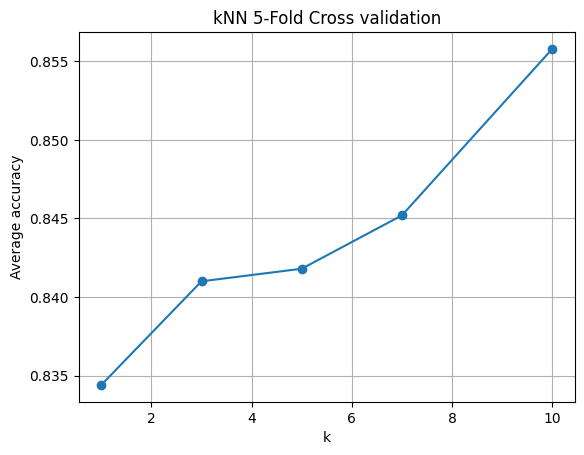

In [ ]:
# Section 2 Question 4
mat = [['K', 'Avg accuracy', 'Avg precision', 'Avg recall']]
X = []
Y = []
for k in knn_score_store:
    acc, prec, rec = np.mean(np.array(knn_score_store[k]), axis=0)
    mat.append([k, acc, prec, rec])
    X.append(k)
    Y.append(acc)
print(fmt_matrix(mat, header_row=True))
print()

plt.plot(X, Y, marker='o')
plt.title('kNN 5-Fold Cross validation')
plt.xlabel('k')
plt.ylabel('Average accuracy')
plt.grid(True)
plt.show()

In [ ]:

class LogisticRegression:
    def __init__(self, max_iterations=1000, learning_rate=0.005, batch_size=1, bnorm=False, init='zeros', early_stopping_iterations = -1):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.weights = None
        self.threshold = None
        self.epsilon = 1e-5
        self.bnorm = bnorm and (batch_size > 1)
        self.max_iterations = max_iterations
        self.init = init
        self.early_stopping_iterations = early_stopping_iterations

    def _generateBatches(self, X, Y):
        batches = []
        size = len(X)
        n_batches = size//self.batch_size + (size%self.batch_size > 0)
        for i in range(n_batches):
            si = i*self.batch_size
            ei = si + self.batch_size
            batches.append((X[si:ei], Y[si:ei]))
        return batches

    def _activation(self, query):
        x = np.sum(query*self.weights, axis=(len(query.shape)-1))
        x = 1/(1 + np.exp(-x))
        return x

    def fit(self, X, Y, valX=None, valY=None):
        x_train = np.append(X, np.ones((X.shape[0],1)), axis=1)
        if (self.weights is None or self.weights.shape != x_train.shape[1:]):
            if (self.init == 'zeros'):
                self.weights = np.zeros(x_train.shape[1:])
            elif (self.init == 'normal'):
                self.weights = np.random.normal(0, 0.1, x_train.shape[1:])
            else:
                raise Exception('Illegal initialization')

        best_results = None # Store (best_iter, best_accuracy, best_threshold, best_weights); Needs valX and valY
        for iteration in range(self.max_iterations):
            for x_batch, y_batch in self._generateBatches(x_train, Y):
                if self.bnorm == True:
                    b_mean = np.mean(x_batch, axis=0)
                    b_var = np.var(x_batch, axis=0)
                    x_batch = b_mean + (x_batch - b_mean)/np.sqrt(b_var + self.epsilon)
                y_pred_batch = self._activation(x_batch)
                # print(x_batch.shape, y_batch.shape, y_pred_batch.shape)
                grad = np.matmul((y_pred_batch - y_batch), x_batch)/self.batch_size
                self.weights -= self.learning_rate * grad

            if valX is not None and valY is not None:
                valY_pred = self.predict_proba(valX)
                threshold, accuracy, *_ = find_eer_scores(valY, valY_pred)

                # Check for best iteration
                if best_results is None or accuracy > best_results[1]:
                    best_results = (iteration, accuracy, threshold, np.copy(self.weights))

                # Check if early stop criterion is met
                if best_results is not None and self.early_stopping_iterations > 0 and iteration - best_results[0] > self.early_stopping_iterations:
                    print(f'Early stopping after {iteration+1} iterations')
                    break

        # Restore to best threshold and weights
        if best_results is not None:
            print(f'Updating weights from Iteration={best_results[0]+1} with Accuracy={best_results[1]:.4f}, Threshold={best_results[2]:.4f}')
            self.threshold = best_results[2]
            self.weights = best_results[3]

        return self

    def predict_proba(self, query):
        if len(query.shape) > 1:
            query = np.append(query, np.ones((query.shape[0],1)), axis=1)
        else:
            query = np.append(query, 1)
        return self._activation(query)

    def update_threshold(self, valX, valY):
        valY_pred = self.predict_proba(valX)
        threshold, accuracy, precision, recall = find_eer_scores(valY, valY_pred)
        self.threshold = threshold
        return accuracy, precision, recall

    def predict(self, query):
        if self.threshold is None:
            raise Exception('Please run update_threshold with validation data to update threshold')
        return (self.predict_proba(query) >= self.threshold).astype(int)


In [ ]:

n_folds = 5
lr_scores = []
for fold_iter, train_idx, val_idx in generateKFolds(len(x_train), n_folds):
    print(f'Running LogisticRegression with fold iter={fold_iter}/{n_folds}')
    # Extract the training and validation data for this fold
    x_fold_train, y_fold_train = x_train[train_idx], y_train[train_idx]
    x_fold_val, y_fold_val = x_train[val_idx], y_train[val_idx]

    lr_model = LogisticRegression(early_stopping_iterations=300)
    lr_model.fit(x_fold_train, y_fold_train, x_fold_val, y_fold_val)

    y_fold_pred = lr_model.predict(x_fold_val)
    _t, *score = find_eer_scores(y_fold_val, y_fold_pred)
    lr_scores.append(score)



Running LogisticRegression with fold iter=1/5


<ipython-input-11-b55b1e190328>:25: RuntimeWarning: overflow encountered in exp
  x = 1/(1 + np.exp(-x))


Early stopping after 502 iterations
Updating weights from Iteration=201 with Accuracy=0.9680, Threshold=0.0000
Running LogisticRegression with fold iter=2/5
Early stopping after 519 iterations
Updating weights from Iteration=218 with Accuracy=0.9750, Threshold=0.8431
Running LogisticRegression with fold iter=3/5
Early stopping after 703 iterations
Updating weights from Iteration=402 with Accuracy=0.9650, Threshold=0.0005
Running LogisticRegression with fold iter=4/5
Early stopping after 483 iterations
Updating weights from Iteration=182 with Accuracy=0.9560, Threshold=0.0000
Running LogisticRegression with fold iter=5/5
Early stopping after 597 iterations
Updating weights from Iteration=296 with Accuracy=0.9310, Threshold=0.9693


In [ ]:
# Section 2 Question 3
mat = [['Fold', 'Accuracy', 'Precision', 'Recall']]
for i in range(n_folds):
    acc, prec, rec = lr_scores[i]
    mat.append([i+1, acc, prec, rec])

print('Scores for Logistic Regression:')
print(fmt_matrix(mat, header_row=True))


Scores for Logistic Regression:
| Fold | Accuracy | Precision          | Recall             |
|——————|——————————|————————————————————|————————————————————|
| 1    | 0.968    | 0.9230769199897093 | 0.9684210492336104 |
| 2    | 0.975    | 0.9374999967447917 | 0.9747292383583782 |
| 3    | 0.965    | 0.9163879568013781 | 0.9647887289972228 |
| 4    | 0.956    | 0.9006410227543558 | 0.9557823096742099 |
| 5    | 0.931    | 0.8558558532857181 | 0.9313725459759067 |


In [ ]:
# Section 2 Question 5

x5_val, y5_val = x_train[:1000], y_train[:1000]
x5_train, y5_train = x_train[1000:], y_train[1000:]

knn_model = KNNModel(k=5).fit(x5_train, y5_train)
knn_preds = knn_model.predict_proba(x5_val)[:,1] # We are only interested in binary classification

lr_model = LogisticRegression(early_stopping_iterations=300).fit(x5_train, y5_train, x5_val, y5_val)
lr_preds = lr_model.predict_proba(x5_val)


<ipython-input-11-b55b1e190328>:25: RuntimeWarning: overflow encountered in exp
  x = 1/(1 + np.exp(-x))


Early stopping after 502 iterations
Updating weights from Iteration=201 with Accuracy=0.9680, Threshold=0.0000


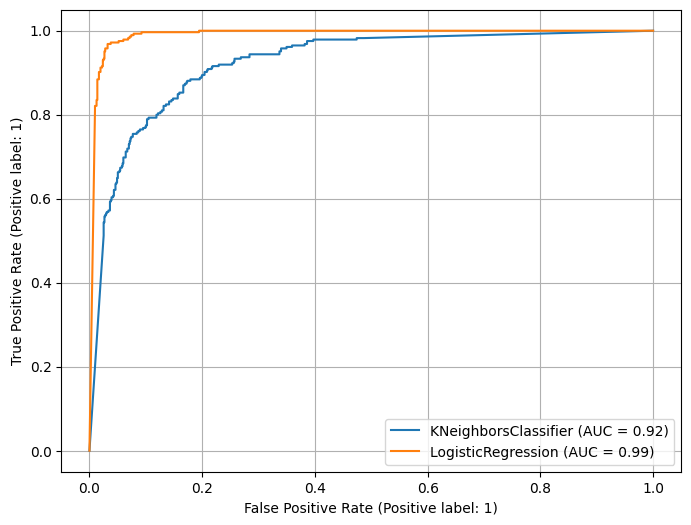

In [ ]:
# Section 2 Question 5 - plot
plot_roc_curves(y5_val, [knn_preds, lr_preds], ['KNeighborsClassifier', 'LogisticRegression'])